In [1]:
#This notebook uses the following dataset: https://www.kaggle.com/datasets/yashpaloswal/esigning-of-loanbased-on-financial-history

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/esigning-of-loanbased-on-financial-history/Financial-Data.csv


This notebook was created on Kaggle, so many of the basic kaggle features are included

First, I will load and investigate the data

In [2]:
df = pd.read_csv('/kaggle/input/esigning-of-loanbased-on-financial-history/Financial-Data.csv')

In [3]:
df.shape

(17908, 21)

In [4]:
df.head()

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,...,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,...,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,...,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


In [5]:
df.drop(columns = ['Entry_id'], inplace = True)

In [6]:
df.columns

Index(['age', 'pay_schedule', 'home_owner', 'income', 'months_employed',
       'years_employed', 'current_address_year', 'personal_account_m',
       'personal_account_y', 'has_debt', 'amount_requested', 'risk_score',
       'risk_score_2', 'risk_score_3', 'risk_score_4', 'risk_score_5',
       'ext_quality_score', 'ext_quality_score_2', 'inquiries_last_month',
       'e_signed'],
      dtype='object')

I now check if there are any duplicate rows to get rid of

In [7]:
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17908 entries, 0 to 17907
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   17908 non-null  int64  
 1   pay_schedule          17908 non-null  object 
 2   home_owner            17908 non-null  int64  
 3   income                17908 non-null  int64  
 4   months_employed       17908 non-null  int64  
 5   years_employed        17908 non-null  int64  
 6   current_address_year  17908 non-null  int64  
 7   personal_account_m    17908 non-null  int64  
 8   personal_account_y    17908 non-null  int64  
 9   has_debt              17908 non-null  int64  
 10  amount_requested      17908 non-null  int64  
 11  risk_score            17908 non-null  int64  
 12  risk_score_2          17908 non-null  float64
 13  risk_score_3          17908 non-null  float64
 14  risk_score_4          17908 non-null  float64
 15  risk_score_5       

I see from the Non-Null Count that there are no null values to handle

In [9]:
df.pay_schedule.value_counts()

bi-weekly       10716
weekly           3696
semi-monthly     2004
monthly          1492
Name: pay_schedule, dtype: int64

Pay schedule takes on 1 of 4 categorical variables, so I will convert this column to a set of binary variables with one hot encoding so that these values can be passed in as inputs to the models

In [10]:
one_hot = pd.get_dummies(df.pay_schedule)

In [11]:
one_hot.rename(columns = lambda x: x + '_pay_schedule', inplace = True)

In [12]:
df.drop('pay_schedule', axis = 1, inplace = True)

In [13]:
df = df.join(one_hot)

In [14]:
df

,age,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,...,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,bi-weekly_pay_schedule,monthly_pay_schedule,semi-monthly_pay_schedule,weekly_pay_schedule
0,40,1,3135,0,3,3,6,2,1,550,...,0.487712,0.515977,0.580918,0.380918,10,1,1,0,0,0
1,61,0,3180,0,6,3,2,7,1,600,...,0.713423,0.826402,0.730720,0.630720,9,0,0,0,0,1
2,23,0,1540,6,0,0,7,1,1,450,...,0.595018,0.762284,0.531712,0.531712,7,0,0,0,0,1
3,40,0,5230,0,6,1,2,7,1,700,...,0.767828,0.778831,0.792552,0.592552,8,1,1,0,0,0
4,33,0,3590,0,5,2,2,8,1,1100,...,0.613487,0.665523,0.744634,0.744634,12,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,31,0,3245,0,5,3,2,6,1,700,...,0.664112,0.838012,0.727705,0.627705,2,0,0,1,0,0
17904,46,0,6525,0,2,1,3,3,1,800,...,0.699241,0.844724,0.774918,0.474918,3,0,1,0,0,0
17905,46,0,2685,0,5,1,1,8,1,1200,...,0.687981,0.939101,0.472045,0.672045,9,0,0,0,0,1
17906,42,0,2515,0,3,5,6,1,1,400,...,0.456448,0.686823,0.406568,0.406568,3,1,1,0,0,0


The time employed and time personal account variables are seperated into months and years, so I combine them into one number that indicates how many years old the person has been employed/ the account has been active

In [15]:
df['time_employed'] = df.months_employed / 12 + df.years_employed

In [16]:
df.drop(['months_employed','years_employed'], axis = 1, inplace = True)

In [17]:
df

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,...,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,bi-weekly_pay_schedule,monthly_pay_schedule,semi-monthly_pay_schedule,weekly_pay_schedule,time_employed
0,40,1,3135,3,6,2,1,550,36200,0.737398,...,0.515977,0.580918,0.380918,10,1,1,0,0,0,3.0
1,61,0,3180,3,2,7,1,600,30150,0.738510,...,0.826402,0.730720,0.630720,9,0,0,0,0,1,6.0
2,23,0,1540,0,7,1,1,450,34550,0.642993,...,0.762284,0.531712,0.531712,7,0,0,0,0,1,0.5
3,40,0,5230,1,2,7,1,700,42150,0.665224,...,0.778831,0.792552,0.592552,8,1,1,0,0,0,6.0
4,33,0,3590,2,2,8,1,1100,53850,0.617361,...,0.665523,0.744634,0.744634,12,0,0,0,1,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,31,0,3245,3,2,6,1,700,71700,0.691126,...,0.838012,0.727705,0.627705,2,0,0,1,0,0,5.0
17904,46,0,6525,1,3,3,1,800,51800,0.648525,...,0.844724,0.774918,0.474918,3,0,1,0,0,0,2.0
17905,46,0,2685,1,1,8,1,1200,59650,0.677975,...,0.939101,0.472045,0.672045,9,0,0,0,0,1,5.0
17906,42,0,2515,5,6,1,1,400,80200,0.642741,...,0.686823,0.406568,0.406568,3,1,1,0,0,0,3.0


In [18]:
df['time_personal_account'] = df.personal_account_m / 12 + df.personal_account_y

In [19]:
df.drop(['personal_account_m','personal_account_y'], axis = 1, inplace = True)

In [20]:
df

,age,home_owner,income,current_address_year,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,...,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,bi-weekly_pay_schedule,monthly_pay_schedule,semi-monthly_pay_schedule,weekly_pay_schedule,time_employed,time_personal_account
0,40,1,3135,3,1,550,36200,0.737398,0.903517,0.487712,...,0.580918,0.380918,10,1,1,0,0,0,3.0,2.500000
1,61,0,3180,3,1,600,30150,0.738510,0.881027,0.713423,...,0.730720,0.630720,9,0,0,0,0,1,6.0,7.166667
2,23,0,1540,0,1,450,34550,0.642993,0.766554,0.595018,...,0.531712,0.531712,7,0,0,0,0,1,0.5,1.583333
3,40,0,5230,1,1,700,42150,0.665224,0.960832,0.767828,...,0.792552,0.592552,8,1,1,0,0,0,6.0,7.166667
4,33,0,3590,2,1,1100,53850,0.617361,0.857560,0.613487,...,0.744634,0.744634,12,0,0,0,1,0,5.0,8.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,31,0,3245,3,1,700,71700,0.691126,0.928196,0.664112,...,0.727705,0.627705,2,0,0,1,0,0,5.0,6.166667
17904,46,0,6525,1,1,800,51800,0.648525,0.970832,0.699241,...,0.774918,0.474918,3,0,1,0,0,0,2.0,3.250000
17905,46,0,2685,1,1,1200,59650,0.677975,0.918141,0.687981,...,0.472045,0.672045,9,0,0,0,0,1,5.0,8.083333
17906,42,0,2515,5,1,400,80200,0.642741,0.885684,0.456448,...,0.406568,0.406568,3,1,1,0,0,0,3.0,1.500000


I rearrange the columns of our dataframe to put our target, e_signed, at the end for aesthetic purposes

In [21]:
df = df[[c for c in df if c not in ['e_signed']] + ['e_signed']]

In [22]:
df

,age,home_owner,income,current_address_year,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,...,ext_quality_score,ext_quality_score_2,inquiries_last_month,bi-weekly_pay_schedule,monthly_pay_schedule,semi-monthly_pay_schedule,weekly_pay_schedule,time_employed,time_personal_account,e_signed
0,40,1,3135,3,1,550,36200,0.737398,0.903517,0.487712,...,0.580918,0.380918,10,1,0,0,0,3.0,2.500000,1
1,61,0,3180,3,1,600,30150,0.738510,0.881027,0.713423,...,0.730720,0.630720,9,0,0,0,1,6.0,7.166667,0
2,23,0,1540,0,1,450,34550,0.642993,0.766554,0.595018,...,0.531712,0.531712,7,0,0,0,1,0.5,1.583333,0
3,40,0,5230,1,1,700,42150,0.665224,0.960832,0.767828,...,0.792552,0.592552,8,1,0,0,0,6.0,7.166667,1
4,33,0,3590,2,1,1100,53850,0.617361,0.857560,0.613487,...,0.744634,0.744634,12,0,0,1,0,5.0,8.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,31,0,3245,3,1,700,71700,0.691126,0.928196,0.664112,...,0.727705,0.627705,2,0,1,0,0,5.0,6.166667,0
17904,46,0,6525,1,1,800,51800,0.648525,0.970832,0.699241,...,0.774918,0.474918,3,1,0,0,0,2.0,3.250000,0
17905,46,0,2685,1,1,1200,59650,0.677975,0.918141,0.687981,...,0.472045,0.672045,9,0,0,0,1,5.0,8.083333,0
17906,42,0,2515,5,1,400,80200,0.642741,0.885684,0.456448,...,0.406568,0.406568,3,1,0,0,0,3.0,1.500000,1


I want to get an idea for the distribution of our datapoints. To do this, I find the mean of the binary columns and the mean and standard deviation of the other columns. In order to perform this split, I first need to make a list of all the columns with binary values

In [23]:
binary_cols = []
for c in df.columns:
    if len(df[c].value_counts()) == 2 and 1 in df[c] and 0 in df[c]:
        binary_cols.append(c)

In [24]:
binary_cols

['home_owner',
 'has_debt',
 'bi-weekly_pay_schedule',
 'monthly_pay_schedule',
 'semi-monthly_pay_schedule',
 'weekly_pay_schedule',
 'e_signed']

In [25]:
for c in df.columns:
    if c in binary_cols:
        mean = df[c].mean()
        print("The percentage of trues in " + c + f" is {mean}")
    else:
        mean = df[c].mean()
        std = df[c].std()
        print("The mean value of " + c + f" is {mean} and the standard deviation is {std}")

The mean value of age is 43.0154121063212 and the standard deviation is 11.873106909579503
The percentage of trues in home_owner is 0.4251731069912888
The mean value of income is 3657.214652669198 and the standard deviation is 1504.890063360771
The mean value of current_address_year is 3.584710743801653 and the standard deviation is 2.75193666406176
The percentage of trues in has_debt is 0.7953987044896136
The mean value of amount_requested is 950.4464485146303 and the standard deviation is 698.5436832136472
The mean value of risk_score is 61086.30221130221 and the standard deviation is 15394.255019831051
The mean value of risk_score_2 is 0.6908776181187738 and the standard deviation is 0.09047039328192538
The mean value of risk_score_3 is 0.8782757628316953 and the standard deviation is 0.05456319219119612
The mean value of risk_score_4 is 0.5831545620014519 and the standard deviation is 0.12506128244136025
The mean value of risk_score_5 is 0.7182519798099732 and the standard deviatio

In [26]:
cols = df.shape[1]

I will check the correlation between the variables to get a sense of which features are linearly correlated with e_signed

In [27]:
df.corr()[["e_signed"]]

,e_signed
age,-0.096998
home_owner,-0.047409
income,0.031377
current_address_year,-0.018969
has_debt,0.039192
amount_requested,0.069572
risk_score,0.086098
risk_score_2,0.010473
risk_score_3,-0.037483
risk_score_4,0.006147


It looks like none of the variables are strongly linearly correlated with e_signed

I now create a dataset of the input features and seperate the e_signed column. Then, I split my data into training data and testing data

In [28]:
X = df.drop(columns = ['e_signed'])
X = X.to_numpy()
y = df['e_signed']

In [29]:
y

0        1
1        0
2        0
3        1
4        0
        ..
17903    0
17904    0
17905    0
17906    1
17907    1
Name: e_signed, Length: 17908, dtype: int64

In [30]:
X_train, X_test,y_train, y_test = train_test_split(X, y)

I investigate the shapes of the split data to ensure that the split occurred properly

In [31]:
X_train.shape

(13431, 20)

In [32]:
X_test.shape

(4477, 20)

First, I will train a Decision Tree and generate predictions

In [33]:
decision_tree = DecisionTreeClassifier(min_samples_leaf = 6)
decision_tree.fit(X_train, y_train)
y_pred_dtree = decision_tree.predict(X_test)

I evaluate the decision tree, and the other two approaches in this notebook, by looking at the model's accuracy and f1 score. Accuracy simply measures what percent of the cases the model got right, while the f1 score measures how often the model predicted true positives out of the number of true positives and false predictions. A high f1 score indicates that the model was able to accurately predict when a loan was e-signed and was not prone to misidentifying outputs, while a low f1 score indicates the opposite relationship. I chose to use this metric because we consider both false negatives and false positices to be bad outcomes

In [34]:
acc_dtree = round(metrics.accuracy_score(y_test, y_pred_dtree), 3) * 100
f1_dtree = round(metrics.f1_score(y_test, y_pred_dtree), 3)
print(f"Decision Tree Accuracy: {acc_dtree} %")
print(f"Decision Tree F1 Score: {f1_dtree}")

Decision Tree Accuracy: 55.400000000000006 %
Decision Tree F1 Score: 0.581


I also look at the confusion matrix for each model. The confusion matrix displays how many false positives, false negatives, true positives, and true negatives occurred

Decision Tree Confusion Matrix: 



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


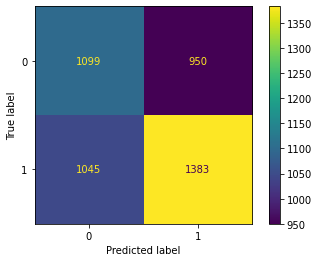

In [35]:
print("Decision Tree Confusion Matrix: \n")
metrics.plot_confusion_matrix(decision_tree, X_test, y_test)

Next, I train and evaluate a random forest classifier

In [36]:
random_forest = RandomForestClassifier(min_samples_leaf = 6)

random_forest.fit(X_train,y_train)
y_pred_random_forest = random_forest.predict(X_test)

In [37]:
acc_rforest = round(metrics.accuracy_score(y_test, y_pred_random_forest), 3) * 100
f1_rforest = round(metrics.f1_score(y_test, y_pred_random_forest),3)
print(f"Random Forest Accuracy: {acc_rforest} %")
print(f"Random Forest F1 Score: {f1_rforest}")

Random Forest Accuracy: 62.8 %
Random Forest F1 Score: 0.667


Random Forest Confusion Matrix: 



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


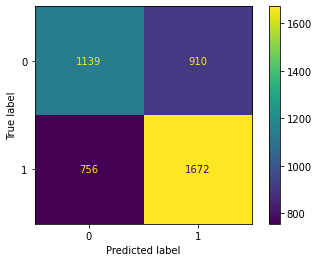

In [38]:
print("Random Forest Confusion Matrix: \n")
metrics.plot_confusion_matrix(random_forest, X_test, y_test)

The next model will be a multilayer perceptron, a popular type of ANN. First, I need to preprocess the data by applying a standard scaler. This scaler will make the data (roughly) follow a standard normal distribution. I didn't do this for the deciison tree and random forest because it would not have changed the final model. This is beneficial for the neural network, however, because it speeds up the training process 

In [39]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
X_train_scaled = np.stack(X_train_scaled, axis = 0)

In [41]:
X_train_scaled.shape

(13431, 20)

In [42]:
X_test_scaled = np.stack(X_test_scaled, axis = 0)

In [43]:
X_test_scaled.shape

(4477, 20)

In [44]:
y_train_array = y_train.to_numpy()

In [45]:
y_train_array = np.reshape(y_train_array, (-1,1))

In [46]:
y_train_array.shape

(13431, 1)

In [47]:
y_test_array = y_test.to_numpy()

I reshape the y-values to make them compatible with the model

In [48]:
y_test_array = np.reshape(y_test_array, (-1,1))

In [49]:
y_test_array.shape

(4477, 1)

In [50]:
mlp = models.Sequential()
mlp.add(Dense(20, input_shape = (X_train_scaled.shape[1],), activation = 'relu'))
mlp.add(Dense(10,activation = 'relu'))
mlp.add(Dense(1, activation = 'relu'))
mlp.compile(optimizer = 'adam', loss = 'mse', metrics = ['binary_accuracy'])

2022-10-05 02:57:35.752891: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The learning rate is lowered to speed up training

In [51]:
K.set_value(mlp.optimizer.learning_rate, 0.0001)

mlp.fit(X_train_scaled, y_train_array, epochs = 125, batch_size = 25)

2022-10-05 02:57:35.994324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/125
538/538 [==============================] - 2s 2ms/step - loss: 0.4042 - binary_accuracy: 0.4808
Epoch 2/125
538/538 [==============================] - 1s 2ms/step - loss: 0.3308 - binary_accuracy: 0.4933
Epoch 3/125
538/538 [==============================] - 1s 2ms/step - loss: 0.3015 - binary_accuracy: 0.5046
Epoch 4/125
538/538 [==============================] - 1s 2ms/step - loss: 0.2846 - binary_accuracy: 0.5170
Epoch 5/125
538/538 [==============================] - 1s 2ms/step - loss: 0.2741 - binary_accuracy: 0.5256
Epoch 6/125
538/538 [==============================] - 1s 2ms/step - loss: 0.2669 - binary_accuracy: 0.5310
Epoch 7/125
538/538 [==============================] - 1s 2ms/step - loss: 0.2617 - binary_accuracy: 0.5374
Epoch 8/125
538/538 [==============================] - 1s 2ms/step - loss: 0.2576 - binary_accuracy: 0.5413
Epoch 9/125
538/538 [==============================] - 1s 2ms/step - loss: 0.2544 - binary_accuracy: 0.5489
Epoch 10/125
538/538 [======

In [52]:
y_pred_mlp = mlp.predict(X_test_scaled)

In [53]:
y_pred_mlp = np.around(y_pred_mlp)

In [54]:
acc_mlp = round(metrics.accuracy_score(y_pred_mlp, y_test), 3) * 100
f1_mlp = round(metrics.f1_score(y_pred_mlp, y_test), 3)
print(f"MLP Accuracy: {acc_mlp} %")
print(f"MLP F1 Score: {f1_mlp}")

MLP Accuracy: 58.9 %
MLP F1 Score: 0.632


I want to compare the performance of all 3 models. To do this, I plot the accuracy and f1 score for each model

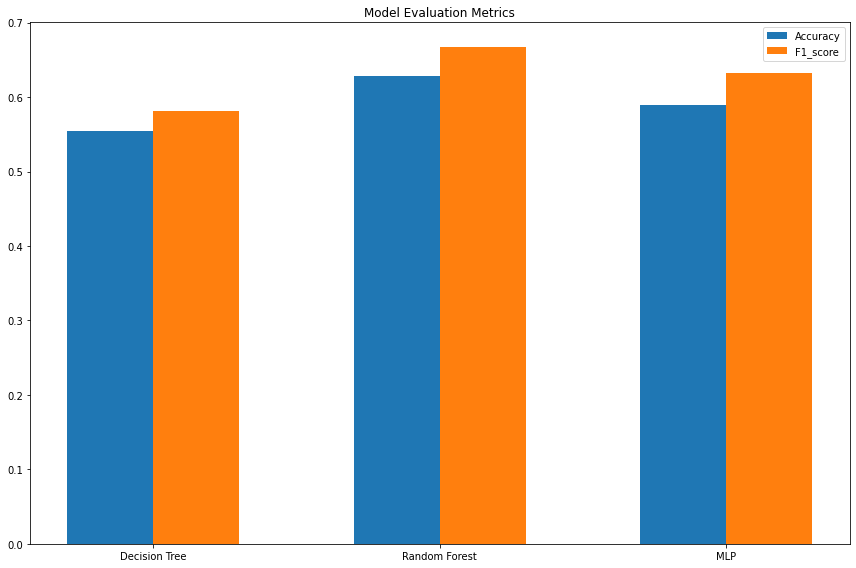

In [55]:
labels = ['Decision Tree', 'Random Forest', 'MLP']
accuracies = [acc_dtree / 100, acc_rforest / 100, acc_mlp / 100] 
f1s = [f1_dtree, f1_rforest, f1_mlp]

x = np.arange(3)
fig, ax = plt.subplots(figsize = (12,8))
acc_rect = ax.bar(x - .15, accuracies, 0.3, label = 'Accuracy')
f1_rect = ax.bar(x + .15, f1s, 0.3, label = 'F1_score')

ax.set_xticks(x, labels)
ax.set_title('Model Evaluation Metrics')

ax.legend()
fig.tight_layout()
plt.show()
